In [ ]:
import cv2 as cv
import numpy as np

In [ ]:
# Copy Files From External Drive To Local Disk

from data.file_utils import Files
import shutil
import os
import numpy as np

db_folder = "/Volumes/DIY_NVME/Bio-informatic project/Exp_20240213_N2_JC01/"
# raw_ds_folder = "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_PARTIAL2/"
raw_ds_folder = "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_RAND/"

file_iter = Files(db_folder)
print(len(file_iter))

video_length = 1000
sample_start_list = range(8000, 58000, 3700)
rnd_fids = np.random.choice(len(file_iter), size=1000, replace=False)

# for i in rnd_fids:
#     src = file_iter.seek(i)
#     filename = file_iter.get_filename()
#     dst = raw_ds_folder + filename
#     shutil.copyfile(src, dst)

# for vid_start in sample_start_list:
#     file_iter.seek(vid_start-1)
#     ret = input(f"Move {video_length} files, strating after {file_iter.get_filename()}? [y/n]")
#     if ret.upper() != 'Y':
#         break
#     for a in range(video_length):
#         src = file_iter.__next__()
#         filename = file_iter.get_filename()
#         dst = raw_ds_folder + filename
#         # os.symlink(src, dst)
#         shutil.copyfile(src, dst)





In [ ]:
cv.destroyAllWindows()

In [ ]:
def image_transform(image: np.ndarray):
    # remove gaussian noise
    image = cv.GaussianBlur(image, (3, 3), 0)

    # quantize image
    N = 50
    image = np.round(image * (N / 255), decimals=0) * (255 / N)

    return image.astype(np.uint8)

In [ ]:
from dataclasses import dataclass
# class to hold the db paths of our pipeline 
@dataclass(frozen=True)
class PATHS:
    raw_db:str
    cropped_db:str
    dlc_db:str


In [ ]:
# define the paths

db_paths =  PATHS(raw_db="/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_02_PARTIAL/",
            cropped_db="/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_02_EXTRACTED/",
            dlc_db="/Users/guycohen/Desktop/Test-Dataset-2024-02-26/labeled-data/output/",
            )
db_paths2 =  PATHS(raw_db="/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_RAND/",
            cropped_db="/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_EXTRACTED2/",
            dlc_db="/Users/guycohen/Desktop/Test-Dataset-2024-02-26/labeled-data/output/",
            )

In [ ]:

db_paths3 =  PATHS(raw_db="/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_PARTIAL",
                   cropped_db="/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_EXTRACTED3000/sample0",
                   dlc_db="asdasdasd",
                  )

In [ ]:
from data.frame_reader import FrameReader
from data.video_extractor import VideoExtractor
from data.file_utils import Files




files = [f for f in Files(db_paths3.raw_db)][:3000]

reader = FrameReader(db_paths3.raw_db, files)
extractor = VideoExtractor(reader, num_workers=4)

In [ ]:
extractor.generate_all_videos((400,400), "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_EXTRACTED3000/sample{}")

In [ ]:
# Initialize frame reader and extractor

from data.frame_reader import FrameReader
from data.video_extractor import VideoExtractor


reader = FrameReader.create_from_directory(db_paths2.raw_db)
extractor = VideoExtractor(reader, num_workers=4)

In [ ]:
sample_path = "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/samples"

extractor.background()

extractor.create_samples(1000, (400,400), sample_path)

In [ ]:
reader = FrameReader.create_from_directory(sample_path)
for f in reader:
    if reader.frame_shape != (400,400):
        print("ERROR")

In [ ]:
from dataset.raw_dataset import *
from data.file_utils import pickle_load_object, pickle_save_object

background = extractor.background()

h, w = reader.frame_shape
exp_meta = ExperimentMeta(60, (w, h), 133.33333, background)
experiment = ExperimentDataset.create_from_frame_reader(reader, exp_meta)

In [ ]:
from data.file_utils import folder_convert_images, rename_raw_file_names, Files
import os

# sample_path = "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/samples/"

# file_iter = Files(sample_path, 'png')

# for file in file_iter:
#     # print(file[:-len(file_iter.get_filename())])
#     new_name = file_iter.get_filename().split('-')[-1]
#     dst = sample_path + new_name
#     os.rename(file, dst)



In [ ]:
# Copy the extracted images to the dlc labeling folder

from data.file_utils import Files
import shutil

every_x_samples = 30
count = 0

directories = Files(db_paths.cropped_db, scan_dirs=True)
for dir in directories:
    file_iter = Files(dir, '.png')
    count += len(file_iter)
    for i in range(0, len(file_iter), every_x_samples):
        file = file_iter.seek(i)
        shutil.copyfile(file, db_paths.dlc_db+file_iter.get_filename())

print(count)

In [ ]:
from view_controller import ViewController

view = ViewController(FrameReader.create_from_directory("sample_all_0"))

while True:
    #view.move_position(5, 5)
    view.visualize_world()
    cv.imshow("micro", view.camera_view())
    cv.waitKey(0)

    if view.progress() == False:
        break
    
cv.destroyAllWindows()

In [ ]:
raise Exception("Finished")

In [ ]:
# TODO: IMPROVE
def find_boxes(image: np.ndarray) -> np.ndarray:
    # increase contrast of original image
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # remove gaussian noise
    smoothed = cv.GaussianBlur(image, (3, 3), 0)

    # apply threshold to image to convert it into black & white
    _, mask = cv.threshold(smoothed, 160, 255, cv.THRESH_BINARY_INV)

    # do some morphological magic to clean up noise from the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)

    # dilate to increase all object sizes in the mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv.dilate(mask, kernel, iterations=5)

    image[mask == 0] = 255
    cv.imshow("masked", image)

    # find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Populate bounding boxes
    bbox_list = []
    for c in contours:
        area = cv.contourArea(c)

        if area < 500 or area > 4000:
            continue

        box = cv.boundingRect(c)
        bbox_list.append(box)

    # Turn our bboxes into 2d ndarray
    bboxes = np.asanyarray(bbox_list)
    return bboxes

In [2]:
import evaluation
config = evaluation.SimConfig.load_from_json("/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Bio-Proj/eval_config.json")
eval = evaluation.Evaluator(config)

{'config': SimConfig(fps=60, micro_view_time_ms=200, tracking_time_ms=50, moving_time_ms=25, frame_time_ms=16.666666666666668, micro_view_frames=12, tracking_frames=3, moving_frames=2, database_path='/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/EXP_01_PARTIAL/', output_path='/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/Eval_v1_test/', YOLO_weights='/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Bio-Proj/yolov8m-trained.pt', px_per_mm=100, camera_size_mm=[4, 4], micro_size_mm=[0.2, 0.2], camera_size_px=(400, 400), micro_size_px=(20, 20), init_position=[1400, 1200], reader_padding_value=[255, 255, 255], tracking_color=[0, 0, 255], moving_color=[255, 255, 255], micro_view_color=[0, 0, 0]), 'output_paths': {'root': '/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/Eval_v1_test/', 'micro': '/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/B

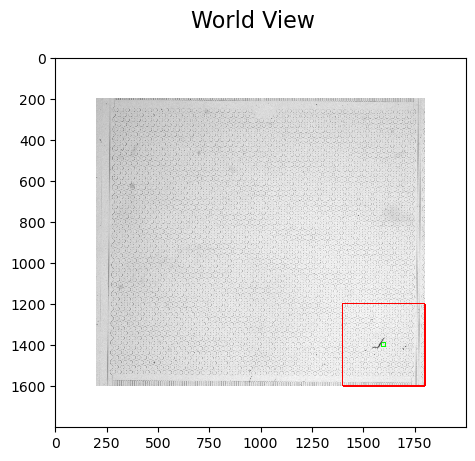

In [3]:
eval.check_init_coords(1400,1200)

In [4]:
ouput_folder = "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/Eval_Partial_first_3000_30px/"

eval.simulate()






0: 416x416 1 Head, 477.8ms
Speed: 3.1ms preprocess, 477.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 498.0ms
Speed: 2.3ms preprocess, 498.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 481.6ms
Speed: 2.2ms preprocess, 481.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 469.6ms
Speed: 3.8ms preprocess, 469.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 495.8ms
Speed: 3.4ms preprocess, 495.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 491.3ms
Speed: 4.0ms preprocess, 491.3ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 504.4ms
Speed: 4.2ms preprocess, 504.4ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Head, 530.2ms
Speed: 1.7ms preprocess, 530.2ms inference, 0.6ms postprocess per image at shape (1, 3, 41

In [ ]:
from image_utils import show_image
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib qt

ouput_folder = "/Users/guycohen/Library/CloudStorage/OneDrive-Technion/1 Courses/Bio Project/Data/MicView_Test4/" + "micro/"

# output = Files(ouput_folder + "micro/", 'png')
out_files = [f for f in Files(ouput_folder, 'png')][90:]
# files = [f for f in Files(db_paths3.raw_db, 'Bmp')][3080:]

output = FrameReader(ouput_folder, out_files, cv.IMREAD_COLOR)
# output = FrameReader.create_from_directory(ouput_folder + "micro/", cv.IMREAD_COLOR)
fig = plt.figure()
ax = fig.gca()


# for file in output:
#     # img = cv.imread(file, cv.IMREAD_COLOR)
#     h = ax.imshow(file, vmin=0, vmax=255, interpolation='none')
#     plt.draw()
#     btn = plt.waitforbuttonpress()
#     while btn is False:
#         btn = plt.waitforbuttonpress()